In [36]:

import sys
import torch
import numpy as np
import pandas as pd

print("Python:", sys.version.splitlines()[0])
print("PyTorch:", torch.__version__)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device:", device)



Python: 3.12.12 (main, Oct 10 2025, 08:52:57) [GCC 11.4.0]
PyTorch: 2.9.0+cu126
Device: cuda


In [37]:

import os
import math
import random
import joblib
from datetime import datetime, timedelta

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

import torch
from torch import nn
from torch.utils.data import Dataset, DataLoader


sns.set_theme(style="whitegrid")


In [38]:
os.path.exists("/content/PRSA_data_2010.1.1-2014.12.31.csv")

True

In [39]:
# CELL 3 — load and inspect
df = pd.read_csv("PRSA_data_2010.1.1-2014.12.31.csv")
print("Shape:", df.shape)
display(df.head())
display(df.columns.tolist())


Shape: (43824, 13)


,No,year,month,day,hour,pm2.5,DEWP,TEMP,PRES,cbwd,Iws,Is,Ir
0,1,2010,1,1,0,NaN,-21,-11.0,1021.0,NW,1.79,0,0
1,2,2010,1,1,1,NaN,-21,-12.0,1020.0,NW,4.92,0,0
2,3,2010,1,1,2,NaN,-21,-11.0,1019.0,NW,6.71,0,0
3,4,2010,1,1,3,NaN,-21,-14.0,1019.0,NW,9.84,0,0
4,5,2010,1,1,4,NaN,-20,-12.0,1018.0,NW,12.97,0,0


['No',
 'year',
 'month',
 'day',
 'hour',
 'pm2.5',
 'DEWP',
 'TEMP',
 'PRES',
 'cbwd',
 'Iws',
 'Is',
 'Ir']

In [40]:
df['datetime'] = pd.to_datetime(df[['year','month','day','hour']])
df = df.sort_values('datetime').reset_index(drop=True)
df = df.set_index('datetime')
display(df[['year','month','day','hour']].head())
print("Index range:", df.index.min(), "→", df.index.max())

,year,month,day,hour
datetime,,,,
2010-01-01 00:00:00,2010,1,1,0
2010-01-01 01:00:00,2010,1,1,1
2010-01-01 02:00:00,2010,1,1,2
2010-01-01 03:00:00,2010,1,1,3
2010-01-01 04:00:00,2010,1,1,4


Index range: 2010-01-01 00:00:00 → 2014-12-31 23:00:00


In [41]:
print("Missing values per column:")
display(df.isna().sum())
display(df.describe().T)

Missing values per column:


,0
No,0
year,0
month,0
day,0
hour,0
pm2.5,2067
DEWP,0
TEMP,0
PRES,0
cbwd,0


,count,mean,std,min,25%,50%,75%,max
No,43824.0,21912.500000,12651.043435,1.00,10956.75,21912.50,32868.25,43824.0
year,43824.0,2012.000000,1.413842,2010.00,2011.00,2012.00,2013.00,2014.0
month,43824.0,6.523549,3.448572,1.00,4.00,7.00,10.00,12.0
day,43824.0,15.727820,8.799425,1.00,8.00,16.00,23.00,31.0
hour,43824.0,11.500000,6.922266,0.00,5.75,11.50,17.25,23.0
pm2.5,41757.0,98.613215,92.050387,0.00,29.00,72.00,137.00,994.0
DEWP,43824.0,1.817246,14.433440,-40.00,-10.00,2.00,15.00,28.0
TEMP,43824.0,12.448521,12.198613,-19.00,2.00,14.00,23.00,42.0
PRES,43824.0,1016.447654,10.268698,991.00,1008.00,1016.00,1025.00,1046.0
Iws,43824.0,23.889140,50.010635,0.45,1.79,5.37,21.91,585.6


In [42]:
# CELL 6 — impute numeric features (NOT target)
# Columns considered as numeric features (excluding pm2.5 which is target)
#Note: we do not have any missing value in our numeric features, cell kept for pipeline robustness
numeric_cols = ['DEWP','TEMP','PRES','Iws','Is','Ir']
# forward-fill then backward-fill small gaps
df[numeric_cols] = df[numeric_cols].ffill().bfill()
# show remaining missingness
print("Missing after imputing numeric inputs:")
display(df[numeric_cols].isna().sum())


Missing after imputing numeric inputs:


,0
DEWP,0
TEMP,0
PRES,0
Iws,0
Is,0
Ir,0


In [43]:
# CELL 7 — one-hot encode cbwd
df['cbwd'] = df['cbwd'].astype(str)  # ensure string
cbwd_dummies = pd.get_dummies(df['cbwd'], prefix='cbwd')
df = pd.concat([df, cbwd_dummies], axis=1)
print("cbwd unique values:", df['cbwd'].unique())
display(cbwd_dummies.head())


cbwd unique values: ['NW' 'cv' 'NE' 'SE']


,cbwd_NE,cbwd_NW,cbwd_SE,cbwd_cv
datetime,,,,
2010-01-01 00:00:00,False,True,False,False
2010-01-01 01:00:00,False,True,False,False
2010-01-01 02:00:00,False,True,False,False
2010-01-01 03:00:00,False,True,False,False
2010-01-01 04:00:00,False,True,False,False


In [44]:
# CELL 8 — features list + cyclical time encoding
# base features (numeric)
base_features = ['DEWP','TEMP','PRES','Iws','Is','Ir']
# one-hot cbwd columns
cbwd_cols = [c for c in df.columns if c.startswith('cbwd_')]
# add cyclical encoding for hour and month
df['hour_sin'] = np.sin(2*np.pi*df['hour']/24.0)
df['hour_cos'] = np.cos(2*np.pi*df['hour']/24.0)
df['month_sin'] = np.sin(2*np.pi*df['month']/12.0)
df['month_cos'] = np.cos(2*np.pi*df['month']/12.0)

time_cols = ['hour_sin','hour_cos','month_sin','month_cos']
feature_cols = base_features + cbwd_cols + time_cols

print("Number of features:", len(feature_cols))
display(feature_cols)


Number of features: 14


['DEWP',
 'TEMP',
 'PRES',
 'Iws',
 'Is',
 'Ir',
 'cbwd_NE',
 'cbwd_NW',
 'cbwd_SE',
 'cbwd_cv',
 'hour_sin',
 'hour_cos',
 'month_sin',
 'month_cos']

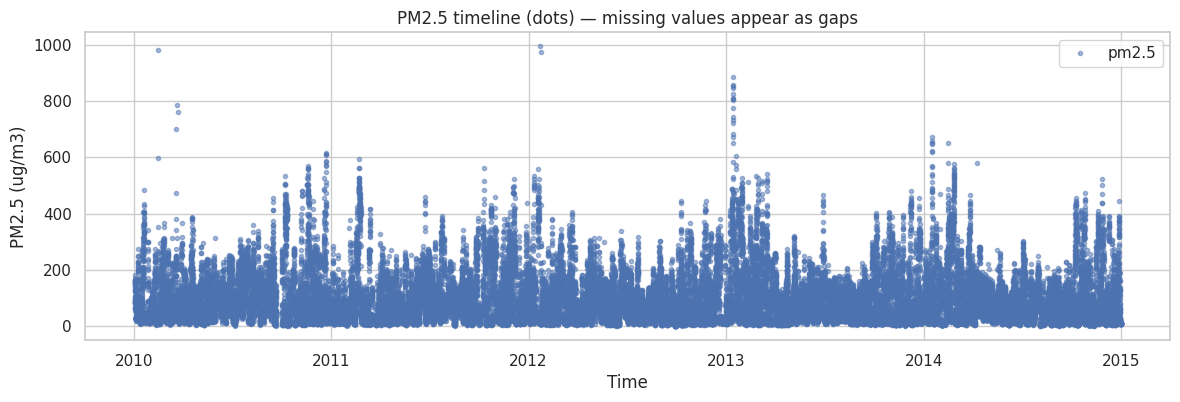

Total rows: 43824
Rows with pm2.5 present: 41757
Rows with pm2.5 missing: 2067


In [45]:
# CELL 9 — plot pm2.5 and highlight missing segments
plt.figure(figsize=(14,4))
plt.plot(df.index, df['pm2.5'], marker='.', linestyle='none', alpha=0.5, label='pm2.5')
plt.title("PM2.5 timeline (dots) — missing values appear as gaps")
plt.xlabel("Time")
plt.ylabel("PM2.5 (ug/m3)")
plt.legend()
plt.show()

print("Total rows:", len(df))
print("Rows with pm2.5 present:", df['pm2.5'].notna().sum())
print("Rows with pm2.5 missing:", df['pm2.5'].isna().sum())


In [46]:
# CELL 10 — prepare index of rows with target present
mask_target = df['pm2.5'].notna()
available_idx = df[mask_target].index

# Chronological split ratios
n = len(available_idx)
train_end = int(n * 0.7)
val_end = int(n * 0.85)

train_idx = available_idx[:train_end]
val_idx = available_idx[train_end:val_end]
test_idx = available_idx[val_end:]

print("Train/Val/Test counts:", len(train_idx), len(val_idx), len(test_idx))


Train/Val/Test counts: 29229 6264 6264


In [47]:
# CELL 11 — sliding window function
def build_sequences(df, feature_cols, target_col='pm2.5', seq_len=12, horizon=0, indices=None):
    """
    Build sequences for LSTM.
    - df: DataFrame indexed by datetime
    - feature_cols: list of column names used as inputs
    - target_col: name of target column
    - seq_len: number of past timesteps used as input
    - horizon: steps ahead from last input to predict (0 means predict at last input time)
    - indices: list/Index of datetimes where target is available and to build windows from (chronological)
    Returns: X (N, seq_len, F), y (N,)
    """
    Xs = []
    ys = []
    idxs = []  # to track timestamps for debugging / alignment
    all_idx = indices if indices is not None else df.index
    for t in all_idx:
        # t is the datetime at which target is measured (we want to predict target at t+horizon)
        target_time = t + pd.Timedelta(hours=horizon)
        # window start
        start_time = t - pd.Timedelta(hours=seq_len-1)
        # Ensure window is fully available in df
        if start_time in df.index and target_time in df.index:
            window = df.loc[start_time:t, feature_cols]
            # ensure correct shape
            if window.shape[0] == seq_len and not window.isna().any().any():
                target_val = df.loc[target_time, target_col]
                # only include if target exists (supervised)
                if not pd.isna(target_val):
                    Xs.append(window.values.astype(np.float32))
                    ys.append(np.float32(target_val))
                    idxs.append(target_time)
    X = np.stack(Xs) if len(Xs)>0 else np.empty((0, seq_len, len(feature_cols)), dtype=np.float32)
    y = np.array(ys, dtype=np.float32)
    return X, y, idxs

# quick test with small seq_len to ensure function runs
_sample_seq_len = 6
X_test, y_test, idx_test = build_sequences(df, feature_cols, seq_len=_sample_seq_len, indices=train_idx[:500])
print("Example shapes (sample):", X_test.shape, y_test.shape)


Example shapes (sample): (500, 6, 14) (500,)


In [48]:
# CELL 12 — create sequences with chosen seq_len
SEQ_LEN = 12
HORIZON = 0  # predict pm2.5 at the last timestep of the window

X_train, y_train, idx_train = build_sequences(df, feature_cols, seq_len=SEQ_LEN, horizon=HORIZON, indices=train_idx)
X_val, y_val, idx_val = build_sequences(df, feature_cols, seq_len=SEQ_LEN, horizon=HORIZON, indices=val_idx)
X_test, y_test, idx_test = build_sequences(df, feature_cols, seq_len=SEQ_LEN, horizon=HORIZON, indices=test_idx)

print("Shapes: train", X_train.shape, y_train.shape, "val", X_val.shape, y_val.shape, "test", X_test.shape, y_test.shape)


Shapes: train (29229, 12, 14) (29229,) val (6264, 12, 14) (6264,) test (6264, 12, 14) (6264,)


In [49]:
# CELL 13 — fit scaler on train only
n_train, seq_len, n_features = X_train.shape
scaler = StandardScaler()
# flatten (N * seq_len, n_features)
X_train_flat = X_train.reshape(-1, n_features)
scaler.fit(X_train_flat)
# transform all datasets
def scale_X(X, scaler):
    nf = X.shape[2]
    Xf = X.reshape(-1, nf)
    Xf = scaler.transform(Xf)
    return Xf.reshape(-1, X.shape[1], nf)

X_train_scaled = scale_X(X_train, scaler)
X_val_scaled = scale_X(X_val, scaler) if X_val.shape[0] > 0 else X_val
X_test_scaled = scale_X(X_test, scaler) if X_test.shape[0] > 0 else X_test

# Save scaler for later (joblib)
joblib.dump(scaler, "scaler.joblib")
print("Scaler saved. Feature mean (train):", scaler.mean_)


Scaler saved. Feature mean (train): [ 1.55149566e+00  1.18076083e+01  1.01635703e+03  2.51860034e+01
  6.88100859e-02  2.21808820e-01  1.12921528e-01  3.30408156e-01
  3.52831663e-01  2.03838653e-01 -5.51366863e-04 -6.00788022e-04
  8.81587374e-02 -3.76724769e-02]


In [51]:
# CELL 14 — PyTorch Dataset class
class PM25Dataset(Dataset):
    def __init__(self, X, y):
        self.X = X  # numpy array (N, seq_len, features)
        self.y = y  # numpy array (N,)
    def __len__(self):
        return len(self.X)
    def __getitem__(self, idx):
        x = torch.from_numpy(self.X[idx]).float()  # shape (seq_len, features)
        y = torch.tensor(self.y[idx]).float()      # shape ()
        return x, y

# Create datasets & dataloaders
BATCH_SIZE = 64

train_dataset = PM25Dataset(X_train_scaled, y_train)
val_dataset = PM25Dataset(X_val_scaled, y_val)
test_dataset = PM25Dataset(X_test_scaled, y_test)

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, drop_last=True)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False, drop_last=False)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False, drop_last=False)

print("Batches per epoch (train/val/test):", len(train_loader), len(val_loader), len(test_loader))


Batches per epoch (train/val/test): 456 98 98


In [52]:
# CELL 15 — Model definition
class LSTMUncertaintyModel(nn.Module):
    def __init__(self, input_size, hidden_size=64, num_layers=2, dropout=0.2):
        super().__init__()
        self.lstm = nn.LSTM(input_size=input_size,
                            hidden_size=hidden_size,
                            num_layers=num_layers,
                            batch_first=True,
                            dropout=dropout)
        # Fully connected heads
        self.fc_mu = nn.Linear(hidden_size, 1)
        self.fc_logvar = nn.Linear(hidden_size, 1)

    def forward(self, x):
        # x shape: (batch, seq_len, features)
        lstm_out, (h_n, c_n) = self.lstm(x)  # lstm_out: (batch, seq_len, hidden)
        # use last timestep output
        last_out = lstm_out[:, -1, :]  # shape (batch, hidden)
        mu = self.fc_mu(last_out).squeeze(-1)           # shape (batch,)
        log_var = self.fc_logvar(last_out).squeeze(-1) # shape (batch,)
        return mu, log_var

# instantiate model
INPUT_SIZE = X_train_scaled.shape[2]
model = LSTMUncertaintyModel(input_size=INPUT_SIZE, hidden_size=64, num_layers=2, dropout=0.3)
model.to(device)
print(model)


LSTMUncertaintyModel(
  (lstm): LSTM(14, 64, num_layers=2, batch_first=True, dropout=0.3)
  (fc_mu): Linear(in_features=64, out_features=1, bias=True)
  (fc_logvar): Linear(in_features=64, out_features=1, bias=True)
)


In [53]:
# CELL 16 — Gaussian negative log-likelihood loss
def gaussian_nll_loss(y_true, mu, log_var, eps=1e-6):
    """
    y_true: tensor (batch,)
    mu: tensor (batch,)
    log_var: tensor (batch,)
    returns: mean loss
    """
    # ensure shapes
    y_true = y_true.view_as(mu)
    # sigma^2 = exp(log_var)
    var = torch.exp(log_var) + eps
    # squared error term scaled by variance
    se = (y_true - mu)**2
    loss = 0.5 * (se / var) + 0.5 * torch.log(var)
    return loss.mean()


In [54]:
import torch
import torch.nn as nn

LR = 1e-3  # learning rate

# Optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=LR, weight_decay=1e-4)

# LR Scheduler
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
    optimizer,
    mode='min',
    factor=0.5,
    patience=3
)

# Define criterion
criterion = gaussian_nll_loss

# Evaluate function
def evaluate_model(model, loader, criterion):
    model.eval()
    total_loss = 0
    preds, targets = [], []
    with torch.no_grad():
        for x, y in loader:
            x, y = x.to(device), y.to(device)
            mu, log_var = model(x)
            loss = criterion(y, mu, log_var)
            total_loss += loss.item() * x.size(0)
            preds.append(mu.cpu())
            targets.append(y.cpu())
    avg_loss = total_loss / len(loader.dataset)
    preds = torch.cat(preds).numpy()
    targets = torch.cat(targets).numpy()
    return avg_loss, preds, targets


In [55]:
EPOCHS = 40
best_val_loss = float('inf')
patience = 6
patience_counter = 0
save_path = "best_lstm_uncertainty.pt"

for epoch in range(1, EPOCHS+1):
    model.train()
    train_losses = []
    for xb, yb in train_loader:
        xb = xb.to(device)
        yb = yb.to(device)
        optimizer.zero_grad()
        mu, log_var = model(xb)
        loss = gaussian_nll_loss(yb, mu, log_var)
        loss.backward()
        optimizer.step()
        train_losses.append(loss.item())
    train_loss = np.mean(train_losses) if len(train_losses) > 0 else None

    # validation
    val_res = evaluate_model(model, val_loader, criterion)
    val_loss = val_res[0] if val_res is not None else None

    # scheduler step on val loss if available
    if val_loss is not None:
        scheduler.step(val_loss)

    # save best
    if val_loss is not None and val_loss < best_val_loss:
        best_val_loss = val_loss
        torch.save({
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'epoch': epoch,

        }, save_path)
        improved = "*"
    else:
        improved = ""

    print(f"Epoch {epoch:02d} | Train Loss: {train_loss:.4f} | Val Loss: {val_loss:.4f} {improved}")


Epoch 01 | Train Loss: 358.9777 | Val Loss: 9.4228 *
Epoch 02 | Train Loss: 7.2248 | Val Loss: 6.5042 *
Epoch 03 | Train Loss: 5.8976 | Val Loss: 5.7959 *
Epoch 04 | Train Loss: 5.5313 | Val Loss: 5.5552 *
Epoch 05 | Train Loss: 5.3994 | Val Loss: 5.4528 *
Epoch 06 | Train Loss: 5.3140 | Val Loss: 5.3638 *
Epoch 07 | Train Loss: 5.2432 | Val Loss: 5.3128 *
Epoch 08 | Train Loss: 5.1917 | Val Loss: 5.2645 *
Epoch 09 | Train Loss: 5.1381 | Val Loss: 5.2103 *
Epoch 10 | Train Loss: 5.0742 | Val Loss: 5.1286 *
Epoch 11 | Train Loss: 4.9982 | Val Loss: 5.0323 *
Epoch 12 | Train Loss: 4.9298 | Val Loss: 4.9873 *
Epoch 13 | Train Loss: 4.8609 | Val Loss: 4.9701 *
Epoch 14 | Train Loss: 4.8141 | Val Loss: 4.8950 *
Epoch 15 | Train Loss: 4.7514 | Val Loss: 4.9962 
Epoch 16 | Train Loss: 4.7106 | Val Loss: 5.0336 
Epoch 17 | Train Loss: 4.6719 | Val Loss: 4.8928 *
Epoch 18 | Train Loss: 4.6453 | Val Loss: 5.0937 
Epoch 19 | Train Loss: 4.6095 | Val Loss: 4.8641 *
Epoch 20 | Train Loss: 4.5494 | 

In [56]:
# CELL 19 — load best and evaluate on test
checkpoint = torch.load("best_lstm_uncertainty.pt", map_location=device)
model.load_state_dict(checkpoint["model_state_dict"])
model.to(device)
test_loss, test_preds, test_targets = evaluate_model(model, test_loader, criterion)

print(f"Test Loss: {test_loss:.4f}")


Test Loss: 4.5007


In [57]:
# CELL 20 — Inverse scaling (PM2.5 only)

# PM2.5 is the first feature in the scaler
pm25_index = 0

# Rebuild fake feature arrays to inverse transform safely
def inverse_pm25(values, scaler, feature_index=0):
    dummy = np.zeros((len(values), scaler.mean_.shape[0]))
    dummy[:, feature_index] = values
    inv = scaler.inverse_transform(dummy)
    return inv[:, feature_index]

y_true = inverse_pm25(test_targets, scaler)
y_pred = inverse_pm25(test_preds, scaler)


In [58]:
# CELL 21 — Evaluation metrics

from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import numpy as np

mae = mean_absolute_error(y_true, y_pred)
rmse = np.sqrt(mean_squared_error(y_true, y_pred))
r2 = r2_score(y_true, y_pred)

print(f"MAE  : {mae:.2f}")
print(f"RMSE : {rmse:.2f}")
print(f"R²   : {r2:.3f}")


MAE  : 734.04
RMSE : 1197.72
R²   : -0.102


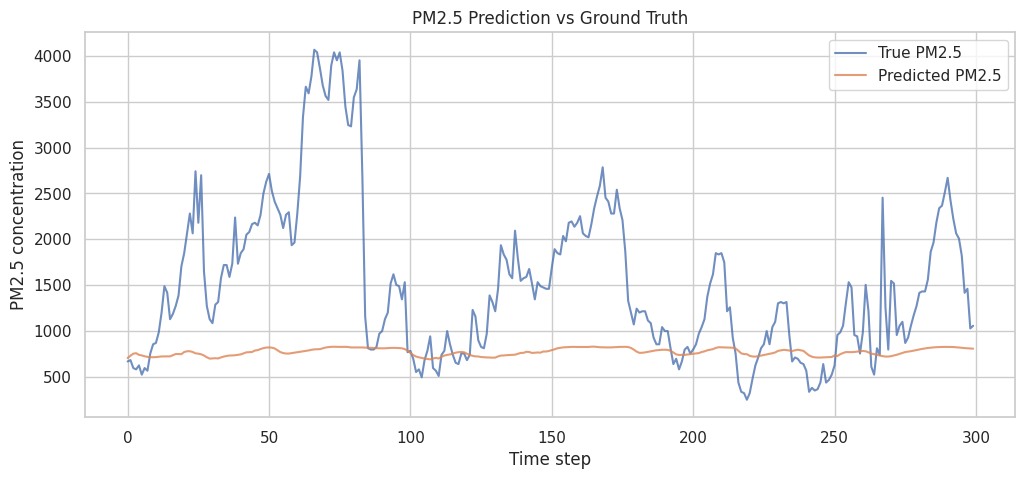

In [59]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12,5))
plt.plot(y_true[:300], label="True PM2.5", alpha=0.8)
plt.plot(y_pred[:300], label="Predicted PM2.5", alpha=0.8)
plt.legend()
plt.title("PM2.5 Prediction vs Ground Truth")
plt.xlabel("Time step")
plt.ylabel("PM2.5 concentration")
plt.grid(True)
plt.show()

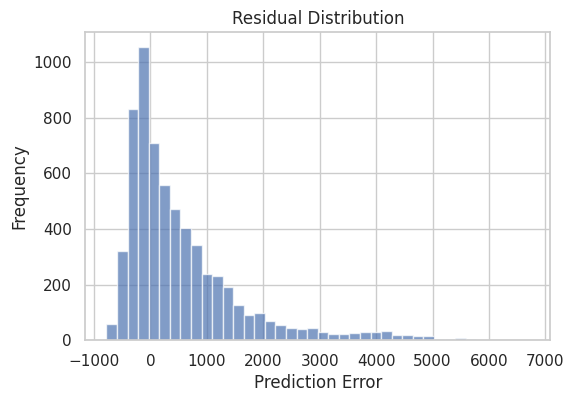

In [60]:
# CELL 23 — Residuals

residuals = y_true - y_pred

plt.figure(figsize=(6,4))
plt.hist(residuals, bins=40, alpha=0.7)
plt.title("Residual Distribution")
plt.xlabel("Prediction Error")
plt.ylabel("Frequency")
plt.grid(True)
plt.show()

In [61]:
# CELL 24 — Predict with uncertainty

model.eval()
with torch.no_grad():
    x, y = next(iter(test_loader))
    x = x.to(device)
    mu, log_var = model(x)
    sigma = torch.exp(0.5 * log_var)

mu = mu.cpu().numpy()
sigma = sigma.cpu().numpy()

# inverse scale
mu = inverse_pm25(mu, scaler)
sigma = sigma * scaler.scale_[0]  # scale uncertainty correctly


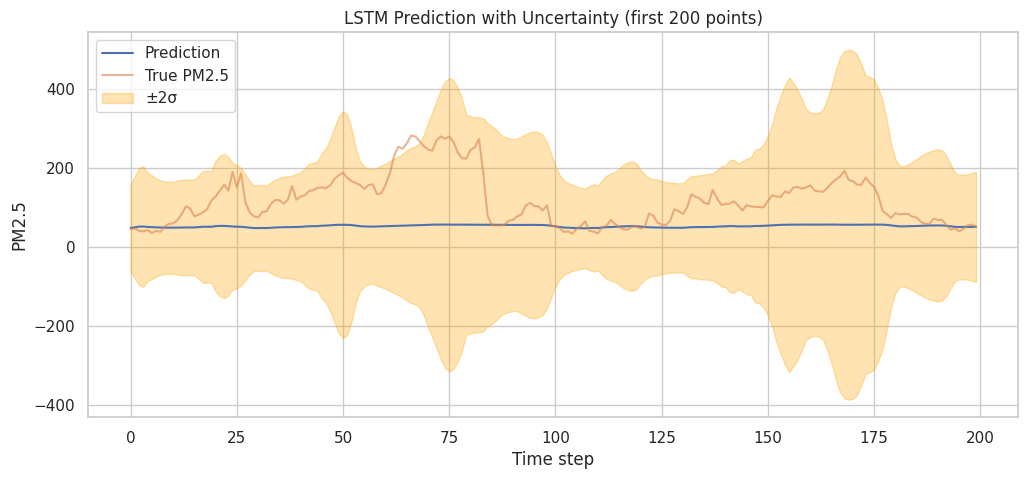

In [62]:
# CELL 23 — Uncertainty plot for first 200 test points

model.eval()
mu_list, sigma_list, y_list = [], [], []

with torch.no_grad():
    for x, y in test_loader:
        x, y = x.to(device), y.to(device)
        mu_batch, log_var_batch = model(x)
        sigma_batch = torch.exp(0.5 * log_var_batch)

        mu_list.append(mu_batch.cpu())
        sigma_list.append(sigma_batch.cpu())
        y_list.append(y.cpu())

# Concatenate all batches
mu_all = torch.cat(mu_list).numpy().flatten()
sigma_all = torch.cat(sigma_list).numpy().flatten()
y_all = torch.cat(y_list).numpy().flatten()

# Choose number of points to plot
n_plot = min(200, len(mu_all))

import matplotlib.pyplot as plt

plt.figure(figsize=(12,5))
plt.plot(mu_all[:n_plot], label="Prediction")
plt.plot(y_all[:n_plot], label="True PM2.5", alpha=0.6)
plt.fill_between(
    range(n_plot),
    mu_all[:n_plot] - 2*sigma_all[:n_plot],
    mu_all[:n_plot] + 2*sigma_all[:n_plot],
    color='orange', alpha=0.3, label="±2σ"
)
plt.xlabel("Time step")
plt.ylabel("PM2.5")
plt.title("LSTM Prediction with Uncertainty (first {} points)".format(n_plot))
plt.legend()
plt.show()


In [63]:
import pandas as pd

results = pd.DataFrame({
    "y_true": y_true,
    "y_pred": y_pred,
    "residual": y_true - y_pred
})

results.to_csv("prediction_results.csv", index=False)
print("Results saved.")

Results saved.
